In [240]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [243]:
# Read in all data
staff = pd.read_csv("../staff_data/staff_raceeth_jobcategories_2010_2015.csv")
students = pd.read_csv("../student_data/student_raceeth_all.csv")
enrollment = pd.read_csv("../student_data/student_enrollment_all.csv", usecols = ["Org Code", "Year", "TOTAL"])
addresses = pd.read_csv("../student_data/school_addresses.csv", encoding = "ISO-8859-1", converters={'Zip Code': str}, usecols = ["Org Code", "Org Name", "Org Type", "Town", "Zip Code", "Grades"])
acs = pd.read_csv("../acs/acs_indicators_by_zip.csv", converters={'Zip Code': str}, usecols = ["Zip Code", "Median Income", "Percent Poverty", "% HS Graduates", "% College Graduates", "Zip Perc White"])

In [245]:
# Remove "-" and convert fields to numeric in ACS data
acs = acs.replace('-', np.NaN)
acs["Median Income"] = acs["Median Income"].apply(pd.to_numeric, errors='coerce')
acs["Percent Poverty"] = acs["Percent Poverty"].apply(pd.to_numeric, errors='coerce')

In [246]:
# Calculate student numbers and staff percents
enrollment = enrollment.rename(columns={"TOTAL": "Total Students"})
students = pd.merge(students, enrollment, on = ["Org Code", "Year"])

In [247]:
staff['% Black (Staff)'] = round(staff['African American (# )'] / staff['FTE Count'] * 100,1)
staff['% Asian (Staff)'] = round(staff['Asian (# )'] / staff['FTE Count'] * 100,1)
staff['% Hispanic (Staff)'] = round(staff['Hispanic (# )'] / staff['FTE Count'] * 100,1)
staff['% White (Staff)'] = round(staff['White (# )'] / staff['FTE Count'] * 100,1)
staff['% Other (Staff)'] = round(staff['Other (# )'] / staff['FTE Count'] * 100,1)

In [ ]:
# Make indicator for schools with non white school leadership

In [248]:
sl_mask = staff["Job Category"] == "School Leaders"
school_leaders = staff[sl_mask]

In [249]:
school_leaders["Non White Leader"] = school_leaders['% White (Staff)'] < 100.0

C:\Users\jillk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [250]:
school_leaders = school_leaders[["Org Code","Non White Leader", "Year"]]

In [251]:
school_leaders.head(5)

,Org Code,Non White Leader,Year
22102,10003,False,2010
22103,10005,False,2010
22104,10015,False,2010
22105,10405,False,2010
22106,10505,False,2010


In [252]:
## Merge staff, school leader indicator, and student data frames
df = pd.merge(staff, school_leaders, how = "left", on = ["Org Code", "Year"])
df = pd.merge(students, df, how= "left", on= ['Org Code','Year'])

In [253]:
# Create non-white staff columns
df['Non White Staff'] = 100 - df['% White (Staff)']
df['Non White Students'] = 100 - df['White']

In [254]:
df.columns

Index(['Org Code', 'SCHOOL_x', 'African American', 'Asian', 'Hispanic',
       'White', 'Native American', 'Native Hawaiian, Pacific Islander',
       'Multi-Race, Non-Hispanic', 'Males', 'Females', 'Source', 'Year',
       'Total Students', 'Job Group', 'SCHOOL_y', 'African American (# )',
       'Asian (# )', 'Hispanic (# )', 'White (# )', 'FTE Count', 'Other (# )',
       'Job Category', '% Black (Staff)', '% Asian (Staff)',
       '% Hispanic (Staff)', '% White (Staff)', '% Other (Staff)',
       'Non White Leader', 'Non White Staff', 'Non White Students'],
      dtype='object')

In [255]:
df = df.drop(['SCHOOL_x', "SCHOOL_y", 'African American (# )', 'Asian (# )', 'White (# )', 'Hispanic (# )', 'Other (# )', 'Native American', 'Native Hawaiian, Pacific Islander', 'Multi-Race, Non-Hispanic', 'Males', 'Females' ], axis=1)

In [256]:
addresses = pd.merge(addresses, acs, how = "inner", on = "Zip Code")

In [257]:
df_zip = pd.merge(df, addresses, how = "inner", on = "Org Code")
df_zip = df_zip.fillna(0)

In [262]:
## Mask for all staff
staff_mask = df_zip["Job Category"] == "All Staff"
df_zip_staff = df_zip[staff_mask]

In [259]:
## Mask for all staff at public schools
staff_public = df_zip["Job Category"] == "All Staff"
staff_public &= df_zip["Org Type"] == "Public School"
df_zip_public = df_zip[staff_public]

In [260]:
## Mask for all staff at charter schools 
staff_charter = df_zip["Job Category"] == "All Staff"
staff_charter &= df_zip["Org Type"] == "Charter School"
df_zip_charter = df_zip[staff_charter]

Explore differences between % nonwhite staff in charter versus public schools and schools with nonwhite leaders

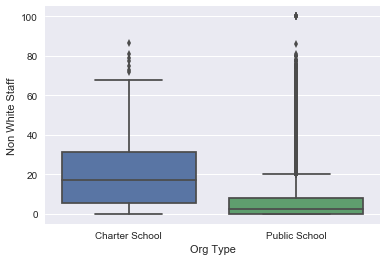

In [263]:
ax = sns.boxplot(x="Org Type", y="Non White Staff", data=df_zip_staff)

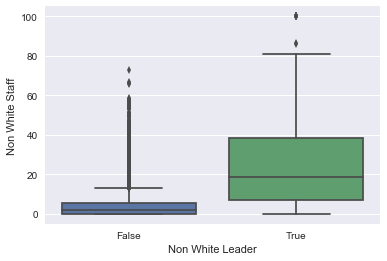

In [264]:
ax = sns.boxplot(x="Non White Leader", y="Non White Staff", data=df_zip_staff)

Explore relationship between % nonwhite students and % nonwhite staff

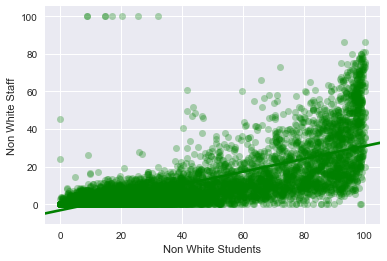

In [265]:
sns.regplot(x = "Non White Students", y = "Non White Staff", data = df_zip_staff, color="g", scatter_kws = {"alpha" : 0.3,});

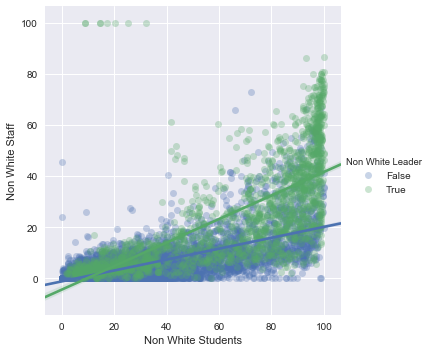

In [266]:
sns.lmplot(x = "Non White Students", y = "Non White Staff", data = df_zip_staff, hue="Non White Leader", scatter_kws = {"alpha" : 0.3,});

In [267]:
df_zip_staff.columns

Index(['Org Code', 'African American', 'Asian', 'Hispanic', 'White', 'Source',
       'Year', 'Total Students', 'Job Group', 'FTE Count', 'Job Category',
       '% Black (Staff)', '% Asian (Staff)', '% Hispanic (Staff)',
       '% White (Staff)', '% Other (Staff)', 'Non White Leader',
       'Non White Staff', 'Non White Students', 'Org Name', 'Org Type', 'Town',
       'Zip Code', 'Grades', 'Median Income', 'Percent Poverty',
       '% HS Graduates', '% College Graduates', 'Zip Perc White'],
      dtype='object')

In [269]:
# Run regression for nonwhite staff at both charter and public schools

ols = smf.ols(formula = "nw_staff ~ C(zip) + nw_stu + nw_sl + med_income + perc_pov + hs_grad + college_grad + total_stu + zip_white",
              data = df_zip_staff.rename(columns = {"Non White Students" : "nw_stu", 
                                          "Non White Staff"  : "nw_staff",
                                                   "Zip Code": "zip",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Median Income": "med_income",
                                                   "Non White Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Zip Perc White": "zip_white"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     116.5
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        18:17:24   Log-Likelihood:                -32496.
No. Observations:               10399   AIC:                         6.585e+04
Df Residuals:                    9971   BIC:                         6.895e+04
Df Model:                         427                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4380      1.190      2.888      0.004       1.105       5.771
C(zip)[T.01002]    -0.6892      0.986     -0.699      0.484      -2.621       1.243
C(zip)[T.01005]     2.2006      1.732      1.271      0.204      -1.194       5.595
C(zip)[T.01007]     0.4456      1.139      0.391      0.696      -1.786       2.677
C(zip)[T.01010]     1.7917      2.389      0.750      0.453      -2.891       6.474
C(zip)[T.01011]     0.9923      2.481      0.400      0.689      -3.871       5.856
C(zip)[T.01012]    -1.1765      2.343     -0.502      0.616      -5.770       3.417
C(zip)[T.01013]    -3.2884      1.279     -2.571      0.010      -5.796      -0.781
C(zip)[T.01020]    -1.6699      1.167     -1.432      0.152      -3.956       0.617
C(zip)[T.01022]    -2.7899      2.109     -1.323      0.186      -6.925       1.345
C(zip)[T.01027]    -2.3794      1.288     -1.847      0.065      -4.905       0.146
C(zip)[T.01028]     0.6154      1.140      0.540      0.589      -1.620       2.851
C(zip)[T.01030]    -0.9931      1.799     -0.552      0.581      -4.519       2.533
C(zip)[T.01031]    -1.0579      2.345     -0.451      0.652      -5.654       3.538
C(zip)[T.01033]     2.9840      1.510      1.976      0.048       0.023       5.945
C(zip)[T.01035]    10.8455      1.479      7.332      0.000       7.946      13.745
C(zip)[T.01036]    -0.3948      1.765     -0.224      0.823      -3.854       3.064
C(zip)[T.01038]    -1.4812      1.865     -0.794      0.427      -5.137       2.175
C(zip)[T.01040]     6.6077      0.748      8.840      0.000       5.142       8.073
C(zip)[T.01050]     0.9155      1.675      0.546      0.585      -2.369       4.200
C(zip)[T.01053]     0.3761      2.292      0.164      0.870      -4.118       4.870
C(zip)[T.01054]    -3.8662      2.285     -1.692      0.091      -8.345       0.613
C(zip)[T.01056]     1.9400      1.359      1.428      0.153      -0.724       4.604
C(zip)[T.01057]     1.4473      1.583      0.915      0.360      -1.655       4.549
C(zip)[T.01060]    -1.1358      1.237     -0.918      0.359      -3.562       1.290
C(zip)[T.01062]    -2.8220      1.620     -1.742      0.082      -5.998       0.354
C(zip)[T.01068]     0.7303      2.373      0.308      0.758      -3.922       5.382
C(zip)[T.01069]     1.5515      1.661      0.934      0.350      -1.705       4.808
C(zip)[T.01071]     1.9594      2.485      0.789      0.430      -2.911       6.830
C(zip)[T.01072]    -0.6961      2.302     -0.302      0.762      -5.208       3.815
C(zip)[T.01073]     1.6562      2.426      0.683      0.495      -3.100       6.413
C(zip)[T.01075]    -0.8454      1.256     -0.673      0.501      -3.307       1.617
C(zip)[T.01077]     3.3489      1.702      1.967      0.049       0.012       6.686
C(zip)[T.01081]    -0.7391      2.579     -0.287      0.774

In [229]:
## Examine coefficients by zip code
co = model.params
co = co.sort_values()
co[0:5]

C(zip)[T.02666]   -12.941849
C(zip)[T.02651]   -11.995385
C(zip)[T.02453]    -9.102130
C(zip)[T.01905]    -9.048532
C(zip)[T.02451]    -8.954446
dtype: float64

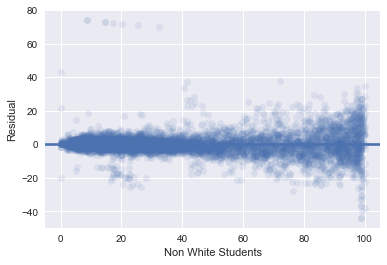

In [231]:
# Examine residuals
sns.regplot(x = df_zip_staff["Non White Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.1});

In [ ]:
## Investigate residuals over 70. This is all Ralph C Mahar, a super small school in Gardner with a non-white school leader

resid = df_zip_staff[model.resid > 70].index
resid = list(resid)
df_zip_staff.loc[resid]

In [41]:
## Investigate residuals below -20
df_zip_staff[model.resid < -20]

,Org Code,African American,Asian,Hispanic,White,Source,Year,Total Students,Job Group,FTE Count,...,Non White Students,Org Name,Org Type,Town,Zip Code,Grades,Median Income,Percent Poverty,% HS Graduates,% College Graduates
252,4120530,58.4,1.4,20.5,16.3,student_raceeth_2014,2014,498,11.0,48.5,...,83.7,Academy Of the Pacific Rim Charter Public (Dis...,Charter School,Hyde Park,02136,"05,06,07,08,09,10,11,12",61391.0,16.8,88.0,25.1
261,4120530,59.0,1.0,21.0,15.8,student_raceeth_2015,2015,519,11.0,55.5,...,84.2,Academy Of the Pacific Rim Charter Public (Dis...,Charter School,Hyde Park,02136,"05,06,07,08,09,10,11,12",61391.0,16.8,88.0,25.1
8172,350545,27.2,22.0,20.0,28.5,student_raceeth_2012,2012,1680,11.0,107.8,...,71.5,Boston: Boston Latin Academy,Public School,Dorchester,02121,"07,08,09,10,11,12",26150.0,40.9,74.4,13.4
8217,350012,38.4,1.8,37.4,19.6,student_raceeth_2011,2011,219,11.0,17.7,...,80.4,Boston: Boston Teachers Union School,Public School,Jamaica Plain,02130,"PK,K,01,02,03,04,05,06,07,08",77480.0,19.3,91.9,64.2
10143,350750,27.3,12.5,41.4,16.4,student_raceeth_2012,2012,128,11.0,43.4,...,83.6,Boston: Horace Mann School for the Deaf,Public School,Allston,02134,"PK,K,01,02,03,05,06,07,08,09,10,11,12",44000.0,15.0,88.6,57.5
11421,350655,22.2,11.1,44.4,22.2,student_raceeth_2010,2010,18,11.0,8.2,...,77.8,Boston: Lyon Upper 9-12,Public School,Brighton,02135,"09,10,11,12",50752.0,20.9,91.1,61.9
12357,350266,23.0,6.6,26.2,40.6,student_raceeth_2012,2012,244,11.0,32.0,...,59.4,Boston: Dr. William Henderson Lower,Public School,Dorchester,02122,"PK,K,01",52122.0,20.8,76.8,22.1
12384,350266,25.7,7.1,23.9,42.0,student_raceeth_2015,2015,226,11.0,43.2,...,58.0,Boston: Dr. William Henderson Lower,Public School,Dorchester,02122,"PK,K,01",52122.0,20.8,76.8,22.1
12447,350278,42.2,2.7,36.1,14.2,student_raceeth_2010,2010,296,11.0,23.5,...,85.8,Boston: Phineas Bates,Public School,Roslindale,02131,"PK,K,01,02,03,04,05",64178.0,20.8,88.8,41.2
12618,350240,26.8,25.1,15.7,29.3,student_raceeth_2011,2011,903,11.0,102.2,...,70.7,Boston: Richard J Murphy,Public School,Dorchester,02122,"PK,K,01,02,03,04,05,06,07,08",52122.0,20.8,76.8,22.1


In [144]:
## Figure out how to look at the data for a set of the schools with the highest number of nonwhite staff members

nw_mask = df_zip_staff["Non White Students"] > 50.0
df_zip_nw = df_zip_staff[nw_mask]

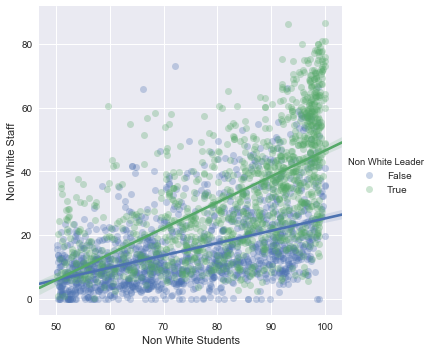

In [145]:
sns.lmplot(x = "Non White Students", y = "Non White Staff", hue="Non White Leader", data = df_zip_nw, scatter_kws = {"alpha" : 0.3,});

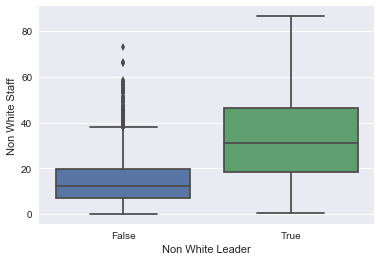

In [146]:
ax = sns.boxplot(x="Non White Leader", y="Non White Staff", data=df_zip_nw)

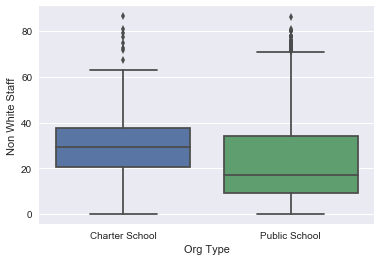

In [205]:
ax = sns.boxplot(x="Org Type", y="Non White Staff", data=df_zip_nw)

Examine models for staff at charter schools and public schools separately

In [270]:
ols = smf.ols(formula = "nw_staff ~ C(zip) + nw_stu + nw_sl + med_income + perc_pov + hs_grad + college_grad + total_stu + zip_white",
              data = df_zip_public.rename(columns = {"Non White Students" : "nw_stu", 
                                          "Non White Staff"  : "nw_staff",
                                                   "Zip Code": "zip",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Median Income": "med_income",
                                                   "Non White Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Zip Perc White": "zip_white"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     132.8
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        18:18:33   Log-Likelihood:                -30288.
No. Observations:               10019   AIC:                         6.143e+04
Df Residuals:                    9592   BIC:                         6.451e+04
Df Model:                         426                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.4187      1.122      4.830      0.000       3.219       7.618
C(zip)[T.01002]    -0.6126      0.893     -0.686      0.493      -2.362       1.137
C(zip)[T.01005]     2.4157      1.567      1.542      0.123      -0.656       5.487
C(zip)[T.01007]     0.6138      1.028      0.597      0.550      -1.401       2.628
C(zip)[T.01010]     2.2863      2.159      1.059      0.290      -1.945       6.518
C(zip)[T.01011]     1.2092      2.243      0.539      0.590      -3.187       5.605
C(zip)[T.01012]    -1.3742      2.117     -0.649      0.516      -5.523       2.775
C(zip)[T.01013]    -2.4854      1.155     -2.151      0.031      -4.750      -0.221
C(zip)[T.01020]    -0.9181      1.056     -0.870      0.385      -2.988       1.152
C(zip)[T.01022]    -8.2694      2.398     -3.449      0.001     -12.969      -3.569
C(zip)[T.01027]    -2.3173      1.198     -1.935      0.053      -4.665       0.030
C(zip)[T.01028]     0.5190      1.031      0.504      0.615      -1.501       2.539
C(zip)[T.01030]    -0.9280      1.625     -0.571      0.568      -4.113       2.257
C(zip)[T.01031]    -1.4385      2.118     -0.679      0.497      -5.590       2.713
C(zip)[T.01033]     3.5274      1.365      2.584      0.010       0.851       6.203
C(zip)[T.01035]    -2.3734      1.578     -1.504      0.133      -5.466       0.719
C(zip)[T.01036]     0.1966      1.595      0.123      0.902      -2.929       3.322
C(zip)[T.01038]    -1.4701      1.686     -0.872      0.383      -4.775       1.834
C(zip)[T.01040]     7.8262      0.709     11.033      0.000       6.436       9.217
C(zip)[T.01050]     0.9204      1.515      0.608      0.544      -2.049       3.890
C(zip)[T.01053]     0.5807      2.072      0.280      0.779      -3.480       4.642
C(zip)[T.01054]    -3.6897      2.065     -1.786      0.074      -7.738       0.359
C(zip)[T.01056]     2.5030      1.227      2.039      0.041       0.097       4.909
C(zip)[T.01057]     1.6873      1.429      1.180      0.238      -1.115       4.489
C(zip)[T.01060]    -1.2933      1.118     -1.157      0.247      -3.485       0.898
C(zip)[T.01062]    -2.8269      1.465     -1.930      0.054      -5.698       0.044
C(zip)[T.01068]     1.1030      2.144      0.514      0.607      -3.100       5.306
C(zip)[T.01069]     2.0170      1.499      1.345      0.179      -0.922       4.956
C(zip)[T.01071]     2.6859      2.246      1.196      0.232      -1.717       7.089
C(zip)[T.01072]    -0.1617      2.080     -0.078      0.938      -4.238       3.915
C(zip)[T.01073]     1.9011      2.193      0.867      0.386      -2.398       6.200
C(zip)[T.01075]    -2.1707      1.225     -1.771      0.077      -4.573       0.231
C(zip)[T.01077]     3.5372      1.538      2.300      0.021       0.523       6.551
C(zip)[T.01081]    -0.2641      2.330     -0.113      0.910

In [271]:
ols = smf.ols(formula = "nw_staff ~ C(zip) + nw_stu + nw_sl + med_income + perc_pov + hs_grad + college_grad + total_stu + zip_white",
              data = df_zip_charter.rename(columns = {"Non White Students" : "nw_stu", 
                                          "Non White Staff"  : "nw_staff",
                                                   "Zip Code": "zip",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Median Income": "med_income",
                                                   "Non White Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Zip Perc White": "zip_white"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     32.79
Date:                Mon, 27 Nov 2017   Prob (F-statistic):          2.35e-105
Time:                        18:18:51   Log-Likelihood:                -1252.9
No. Observations:                 380   AIC:                             2630.
Df Residuals:                     318   BIC:                             2874.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.0960      1.903     -3.728      0.000     -10.841      -3.351
C(zip)[T.01027]     3.9850      3.907      1.020      0.309      -3.701      11.671
C(zip)[T.01035]    30.2815      3.372      8.980      0.000      23.647      36.916
C(zip)[T.01040]    -2.8214      3.669     -0.769      0.442     -10.039       4.396
C(zip)[T.01075]     8.2298      3.469      2.372      0.018       1.405      15.055
C(zip)[T.01104]    -2.6513      5.099     -0.520      0.603     -12.684       7.381
C(zip)[T.01105]    -9.3720      3.927     -2.387      0.018     -17.097      -1.647
C(zip)[T.01108]    11.7350      3.213      3.652      0.000       5.413      18.057
C(zip)[T.01129]    -3.5637      4.431     -0.804      0.422     -12.282       5.155
C(zip)[T.01220]     4.7872      3.648      1.312      0.190      -2.390      11.965
C(zip)[T.01301]     6.7338      3.900      1.727      0.085      -0.939      14.407
C(zip)[T.01420]     6.6052      3.523      1.875      0.062      -0.326      13.537
C(zip)[T.01434]    15.8250      3.826      4.137      0.000       8.298      23.352
C(zip)[T.01605]    -0.1996      2.982     -0.067      0.947      -6.067       5.668
C(zip)[T.01606]   -11.2180      4.419     -2.539      0.012     -19.912      -2.524
C(zip)[T.01701]     1.5608      3.111      0.502      0.616      -4.561       7.682
C(zip)[T.01752]    10.1794      3.439      2.960      0.003       3.413      16.946
C(zip)[T.01832]     2.3957      3.405      0.704      0.482      -4.303       9.095
C(zip)[T.01835]    -0.1482      3.190     -0.046      0.963      -6.425       6.129
C(zip)[T.01840]   -14.7892      3.196     -4.628      0.000     -21.076      -8.502
C(zip)[T.01841]    -8.2738      2.663     -3.107      0.002     -13.513      -3.035
C(zip)[T.01851]    -2.5411      5.029     -0.505      0.614     -12.435       7.353
C(zip)[T.01852]    -3.1673      2.215     -1.430      0.154      -7.525       1.190
C(zip)[T.01879]    10.1282      3.037      3.334      0.001       4.152      16.104
C(zip)[T.01902]    -0.7083      3.001     -0.236      0.814      -6.612       5.195
C(zip)[T.01906]   -20.8468      5.811     -3.588      0.000     -32.279      -9.414
C(zip)[T.01945]     1.8352      3.175      0.578      0.564      -4.412       8.082
C(zip)[T.01950]     5.5219      3.263      1.692      0.092      -0.898      11.941
C(zip)[T.01970]     2.1189      3.078      0.688      0.492      -3.938       8.176
C(zip)[T.02035]     2.4143      3.528      0.684      0.494      -4.528       9.356
C(zip)[T.02038]    -1.3232      2.947     -0.449      0.654      -7.122       4.475
C(zip)[T.02061]    -1.5269      3.079     -0.496      0.620      -7.585       4.531
C(zip)[T.02115]    11.3589      2.737      4.151      0.000       5.974      16.743
C(zip)[T.02119]    10.6882      2.343      4.561      0.000